# DS-SF-36 | 06 | $k$-Nearest Neighbors | Assignment | Starter Code

## $k$-Nearest Neighbors and Boston

In [70]:
import os

import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

from sklearn import preprocessing, neighbors, model_selection

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [71]:
df = pd.read_csv(os.path.join('..', 'datasets', 'dataset-06-boston.csv'))

The Boston dataset concerns itself with housing values in suburbs of Boston.  A description of the dataset is as follows:

- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sqft
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River binary/dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centers
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate (per ten thousands of dollars)
- PTRATIO: pupil-teacher ratio by town
- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT: % lower status of the population
- MEDV: Median value of owner-occupied homes (in thousands of dollars)

> ### Question 1.  Let's first categorize `MEDV` to 4 groups: Bottom 20% as Level 1, next 30% as Level 2, next 30% categorized as Level 3, and the top 20% as Level 4.  Please create a new variable `MEDV_Category` that stores the level number

In [72]:
#Data Polishing

df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
            ...   
TAX          int64
PTRATIO    float64
BLACK      float64
LSTAT      float64
MEDV       float64
Length: 14, dtype: object

MEDV has not unwanted data, no data clean required

In [73]:
Q20 = df.MEDV.quantile(.20)

Q20

15.3

In [74]:
Q50 = df.MEDV.mean()
Q50

22.532806324110698

In [75]:
Q80 = df.MEDV.quantile(.80)
Q80

28.2

In [76]:
def classify_medv(medv):
    if( medv <=Q20):
        return 'Level 1'
    elif(medv > Q20 and medv <= Q50):
        return 'Level 2'
    elif(medv > Q50 and medv <= Q80):
        return 'Level 3'
    else:
        return 'Level 4'
    
        

In [77]:
df['MEDV_Category']=df.MEDV.apply(lambda medv: classify_medv(medv))

In [78]:
df

,CRIM,ZN,INDUS,CHAS,NOX,...,PTRATIO,BLACK,LSTAT,MEDV,MEDV_Category
0,0.00632,18.0,2.31,0,0.538,...,15.3,396.90,4.98,24.0,Level 3
1,0.02731,0.0,7.07,0,0.469,...,17.8,396.90,9.14,21.6,Level 2
2,0.02729,0.0,7.07,0,0.469,...,17.8,392.83,4.03,34.7,Level 4
3,0.03237,0.0,2.18,0,0.458,...,18.7,394.63,2.94,33.4,Level 4
4,0.06905,0.0,2.18,0,0.458,...,18.7,396.90,5.33,36.2,Level 4
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,...,21.0,391.99,9.67,22.4,Level 2
502,0.04527,0.0,11.93,0,0.573,...,21.0,396.90,9.08,20.6,Level 2
503,0.06076,0.0,11.93,0,0.573,...,21.0,396.90,5.64,23.9,Level 3
504,0.10959,0.0,11.93,0,0.573,...,21.0,393.45,6.48,22.0,Level 2


In [79]:
df[['MEDV','MEDV_Category']].groupby('MEDV_Category').count()

,MEDV
MEDV_Category,
Level 1,102
Level 2,195
Level 3,108
Level 4,101


## Our goal is to predict `MEDV_Category` based on `RM`, `PTRATIO`, and `LSTAT`

> ### Question 2.  First normalize `RM`, `PTRATIO`, and `LSTAT`.  By normalizing, we mean to scale each variable between 0 and 1 with the lowest value as 0 and the highest value as 1

In [63]:
df[['RM','PTRATIO','LSTAT']].head()

,RM,PTRATIO,LSTAT
0,6.575,15.3,4.98
1,6.421,17.8,9.14
2,7.185,17.8,4.03
3,6.998,18.7,2.94
4,7.147,18.7,5.33


In [90]:
def get_norm_value(d):
    return (d-d.min())/(d.max()-d.min());

In [91]:
df[['RM','PTRATIO','LSTAT']].apply(get_norm_value)

,RM,PTRATIO,LSTAT
0,0.577505,0.287234,0.089680
1,0.547998,0.553191,0.204470
2,0.694386,0.553191,0.063466
3,0.658555,0.648936,0.033389
4,0.687105,0.648936,0.099338
...,...,...,...
501,0.580954,0.893617,0.219095
502,0.490324,0.893617,0.202815
503,0.654340,0.893617,0.107892
504,0.619467,0.893617,0.131071


In [65]:
_min = df.RM.min()
_max = df.RM.max()
df.RM=df.RM.apply(lambda rm: get_norm_value(rm, _min, _max))
df.RM

0      0.577505
1      0.547998
2      0.694386
3      0.658555
4      0.687105
         ...   
501    0.580954
502    0.490324
503    0.654340
504    0.619467
505    0.473079
Name: RM, Length: 506, dtype: float64

In [66]:
_min = df.PTRATIO.min()
_max = df.PTRATIO.max()
df.PTRATIO=df.PTRATIO.apply(lambda rm: get_norm_value(rm, _min, _max))
df.PTRATIO

0      0.287234
1      0.553191
2      0.553191
3      0.648936
4      0.648936
         ...   
501    0.893617
502    0.893617
503    0.893617
504    0.893617
505    0.893617
Name: PTRATIO, Length: 506, dtype: float64

In [67]:
_min = df.LSTAT.min()
_max = df.LSTAT.max()
df.LSTAT=df.LSTAT.apply(lambda rm: get_norm_value(rm, _min, _max))
df.LSTAT

0      0.089680
1      0.204470
2      0.063466
3      0.033389
4      0.099338
         ...   
501    0.219095
502    0.202815
503    0.107892
504    0.131071
505    0.169702
Name: LSTAT, Length: 506, dtype: float64

In [69]:
#sanity check
df[['RM','PTRATIO','LSTAT']].describe()

,RM,PTRATIO,LSTAT
count,506.000000,506.000000,506.000000
mean,0.521869,0.622929,0.301409
std,0.134627,0.230313,0.197049
min,0.000000,0.000000,0.000000
25%,0.445392,0.510638,0.144040
50%,0.507281,0.686170,0.265728
75%,0.586798,0.808511,0.420116
max,1.000000,1.000000,1.000000


> ### Question 3.  Run a $k$-Nearest Neighbor classifier with 5 nearest neighbors and report your misclassification error; set `weights` to `uniform`

In [101]:
columns_X = ['RM','PTRATIO','LSTAT']
X = df[columns_X]

scaler = preprocessing.MinMaxScaler().fit(X)

X = scaler.transform(X)

In [102]:
c = df.MEDV_Category

In [103]:
model = neighbors.KNeighborsClassifier(n_neighbors = 5, weights='uniform').fit(X, c)

# Accuracy

In [104]:
model.score(X, c)

0.79644268774703553

In [111]:
#Method 02 

(c_hat ==c).mean()

0.79644268774703553

# Misclassification Rate

In [113]:
(c_hat !=c).mean()

0.20355731225296442

Answer: 0.20355731225296442

In [105]:
c_hat =model.predict(X)

In [106]:
pd.crosstab(c_hat, c, rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,Level 1,Level 2,Level 3,Level 4
Hypothesized Class,,,,
Level 1,87,20,2,0
Level 2,15,161,31,6
Level 3,0,13,69,9
Level 4,0,1,6,86


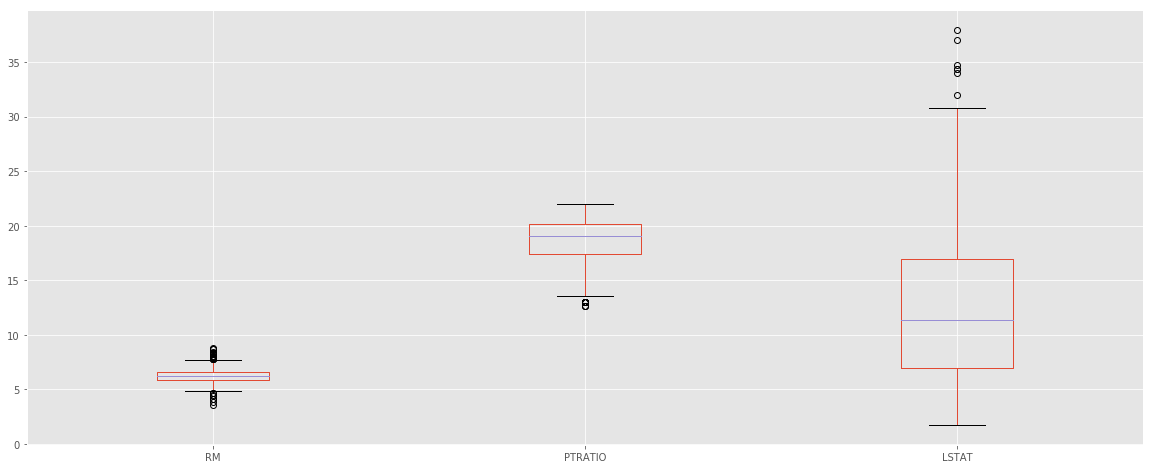

In [116]:
df[columns_X].plot(kind ='box', figsize =(20,8))

> ### Question 4.  Is this error reliable?

Answer: 20% error rate is not reliable. This error is because of more number of outliers in RM and LSTAT variables.

> ### Question 5.  Now use 10-fold cross-validation to choose the most efficient `k`

In [ ]:
# TODO

> ### Question 6.  Explain your findings

Answer: TODO

> ### Question 7.  Train your model with the optimal `k` you found above (don't worry if it changes from time to time - if that is the case use the one that is usually the best)

In [ ]:
# TODO

Answer: TODO

> ### Question 8.  After training your model with that `k`, use it to predict the class of a neighborhood with `RM = 2`, `PRATIO = 19`, and `LSTAT = 3.5`

In [ ]:
# TODO

Answer: TODO